In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import mne
import pathlib
import sklearn
import hdbscan
import seaborn as sns
import statistics
from meegkit import dss

from pycrostates.preprocessing import extract_gfp_peaks
from proof_of_consept import unit_normalize
from neurokit2.microstates.microstates_clean import microstates_clean
from mne_icalabel import label_components
from scipy.stats import kurtosis, skew

In [2]:
def zapline_clean(raw, fline):
    data = raw.get_data().T # Convert mne data to numpy darray
    sfreq = raw.info['sfreq'] # Extract the sampling freq
   
    #Apply MEEGkit toolbox function
    out, _ = dss.dss_line(data, fline, sfreq, nkeep=1) # fline (Line noise freq) = 50 Hz for Europe
    print(out.shape)

    cleaned_raw = mne.io.RawArray(out.T, raw.info) # Convert output to mne RawArray again

    return cleaned_raw

In [3]:
data_folder = pathlib.Path(r"C:\Users\Gulbr\MasterOppgave\SRM_rs_EEG_OpenNeuro")
file = data_folder / "sub-001_ses-t1_task-resteyesc_eeg.edf"
processed_folder = pathlib.Path(r"C:\Users\Gulbr\MasterOppgave\SRM_rs_EEG_OpenNeuro_cleaned")
processed_file = processed_folder / "sub-001_ses-t1_task-resteyesc_desc-epochs_eeg.set"

raw = mne.io.read_raw_edf(file, preload=True, verbose=False)
#mne.set_eeg_reference(raw, copy=False, verbose=False)
#Be carefull that artifact electrodes are not included in the average calc.
print(raw.info['ch_names'])
raw.set_montage('biosemi64')
#raw.drop_channels('O2')#raw.info["bads"].append("O2")
#mne.set_eeg_reference(raw, copy=False, verbose=False)
#raw.set_montage('biosemi64')

#bridged, dist = mne.preprocessing.compute_bridged_electrodes(raw)


raw_highpass = raw.copy().filter(l_freq=1, h_freq=None, verbose=False)
raw_lowpass = raw_highpass.copy().filter(l_freq=None, h_freq=100, verbose=False)
line_noise = zapline_clean(raw_lowpass, 50)
raw_down_sampled = line_noise.copy().resample(sfreq=200, verbose=False)
raw_down_sampled.set_eeg_reference(ref_channels='average')
#I should maybe downsample, and maybe do it first for computational efficiency. The only thing is that then almost all the data will be in simpochs, so maybe I need stricter limits for gfp peakes.
#Bad segments can maybe be identified with Christoffers algorithm, anything else? I want to do this at the end of the pipeline I think.

['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2']
[PCA] Explained variance of selected components : 63.02%
Power of components removed by DSS: 0.18
(245760, 64)
Creating RawArray with float64 data, n_channels=64, n_times=245760
    Range : 0 ... 245759 =      0.000 ...   239.999 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


<RawArray | 64 x 48000 (240.0 s), ~23.5 MB, data loaded>

In [4]:
def gfp_normed_diss_data(indices, data, gfp):
    all_inx = np.arange(data.shape[1])
    unorderd_adj_indices = np.array([indices, (indices-1)]).flatten()
    anti_adj_indices = np.delete(all_inx, unorderd_adj_indices)
    all_inx = np.arange(data.shape[1])
    adj_indices = np.delete(all_inx, anti_adj_indices)

    indexed_data = data[:, adj_indices]
    indexed_gfp = gfp[adj_indices]

    gfp_normed = indexed_data/indexed_gfp


    return gfp_normed

def gfp_normed_diss_data2(indices, data, gfp):
    indexed_data = data[:, indices]
    indexed_gfp = gfp[indices]

    gfp_normed = indexed_data/indexed_gfp


    return gfp_normed

In [5]:
def diss(data, gfp, indices):
    gfp_normed_data = gfp_normed_diss_data(indices, data, gfp)
    diss = np.ndarray(shape=(len(indices), data.shape[0]))
    for t in range(0, len(indices)*2, 2):
        diss[int(t/2), :] = np.square(gfp_normed_data[:, t] - gfp_normed_data[:, t+1])
    return diss

def diss2(data, gfp, indices):
    gfp_normed_data = gfp_normed_diss_data2(indices, data, gfp)
    diss = np.ndarray(shape=(len(indices)-1, data.shape[0]))
    for t in range(1, len(indices)):
        diss[t-1, :] = np.square(gfp_normed_data[:, t] - gfp_normed_data[:, t-1])
    return diss

In [6]:
def epoched_stability1(epochs_object):
    epochs_array = epochs_object.get_data()
    stability = np.ndarray(shape=(epochs_array.shape[0]))
    convex_stabilty = np.ndarray(shape=(epochs_array.shape[0]))
    for e in range(epochs_array.shape[0]):
        data, indices, gfp, info_mne  = microstates_clean(epochs_array[e, :, :], standardize_eeg=False, normalize=False, gfp_method='l2', sampling_rate=epochs_object.info['sfreq'])
        d = diss(data, gfp, indices)
        individual_map_stability = np.sqrt(np.mean(d, 1)) - 1
        for_convex = np.sqrt(np.mean(d, 1))
        stability[e] = np.mean(np.abs(individual_map_stability))
        convex_stabilty[e] = np.mean(for_convex)
    return stability, convex_stabilty

def epoched_stability2(epochs_object):
    epochs_array = epochs_object.get_data()
    stability = np.ndarray(shape=(epochs_array.shape[0]))
    convex_stability = np.ndarray(shape=(epochs_array.shape[0]))
    switching_freq = np.ndarray(shape=(epochs_array.shape[0]))
    significant_switching_freq = np.ndarray(shape=(epochs_array.shape[0]))
    peaks = np.ndarray(shape=(epochs_array.shape[0]))
    for e in range(epochs_array.shape[0]):
        data, indices, gfp, info_mne  = microstates_clean(epochs_array[e, :, :], standardize_eeg=False, normalize=False, gfp_method='l2', sampling_rate=epochs_object.info['sfreq'])
        if e == 0:
            data_at_peaks = data[:, indices]
            full_data = data
        else:
            data_at_peaks = np.concatenate((data_at_peaks, data[:, indices]), axis=1)
            full_data = np.concatenate((full_data, data), axis=1)
        d = diss2(data, gfp, indices)
        individual_map_stability = np.sqrt(np.mean(d, 1)) - 1
        for_convex = np.sqrt(np.mean(d, 1))
        freq = 0
        sfreq = 0
        for s in individual_map_stability:
            if s > 0:
                freq += 1
            if s > 0.4:
                sfreq += 1
        switching_freq[e] = freq
        significant_switching_freq[e] = sfreq
        stability[e] = np.mean(np.abs(individual_map_stability))
        convex_stability[e] = np.mean(for_convex)
        peaks[e] = len(indices)
    return stability, switching_freq, convex_stability, significant_switching_freq, peaks, full_data, data_at_peaks

What happens with ICA applied?

In [7]:
epocs_ica = mne.make_fixed_length_epochs(raw_down_sampled, verbose=False, preload=True, overlap=0.5)
#epocs_ica.drop([200, 201, 202, 203, 204, 205, 216, 217, 218, 219, 220, 221, 222]) #Removing the obv bad epochs.

In [8]:
ica_a = mne.preprocessing.ICA(max_iter="auto",
    method="infomax",
    random_state=97,
    fit_params=dict(extended=True),
    )

In [9]:
ica_a.fit(epocs_ica)
#Do I feed enough data to ICA?

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 63 components
Computing Extended Infomax ICA
Fitting ICA took 264.3s.


Method,infomax
Fit,133 iterations on epochs (95800 samples)
ICA components,63
Available PCA components,64
Channel types,eeg
ICA components marked for exclusion,—


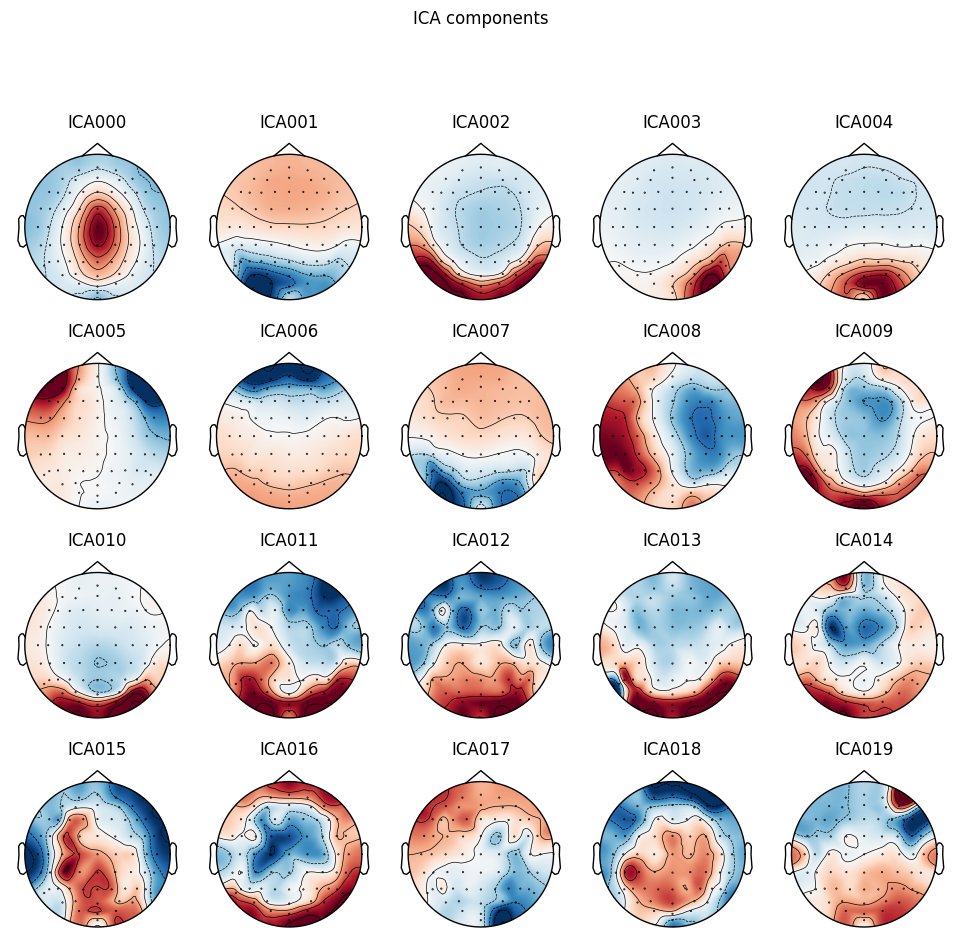

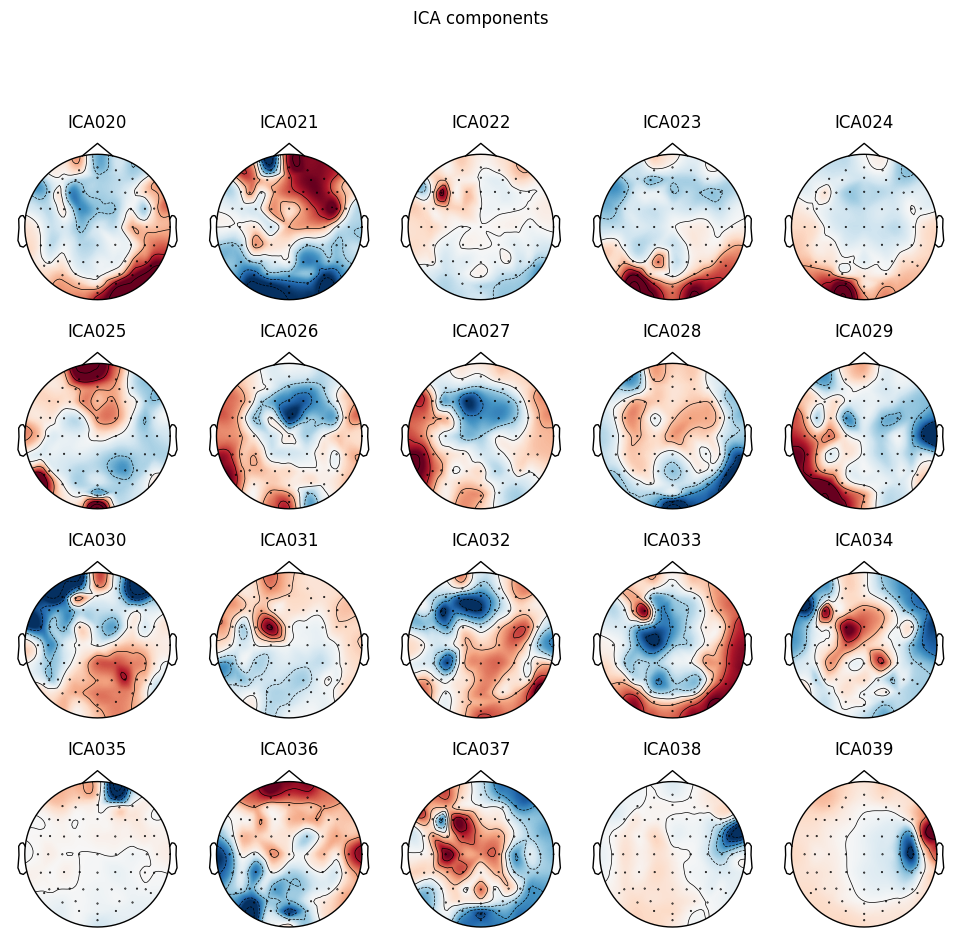

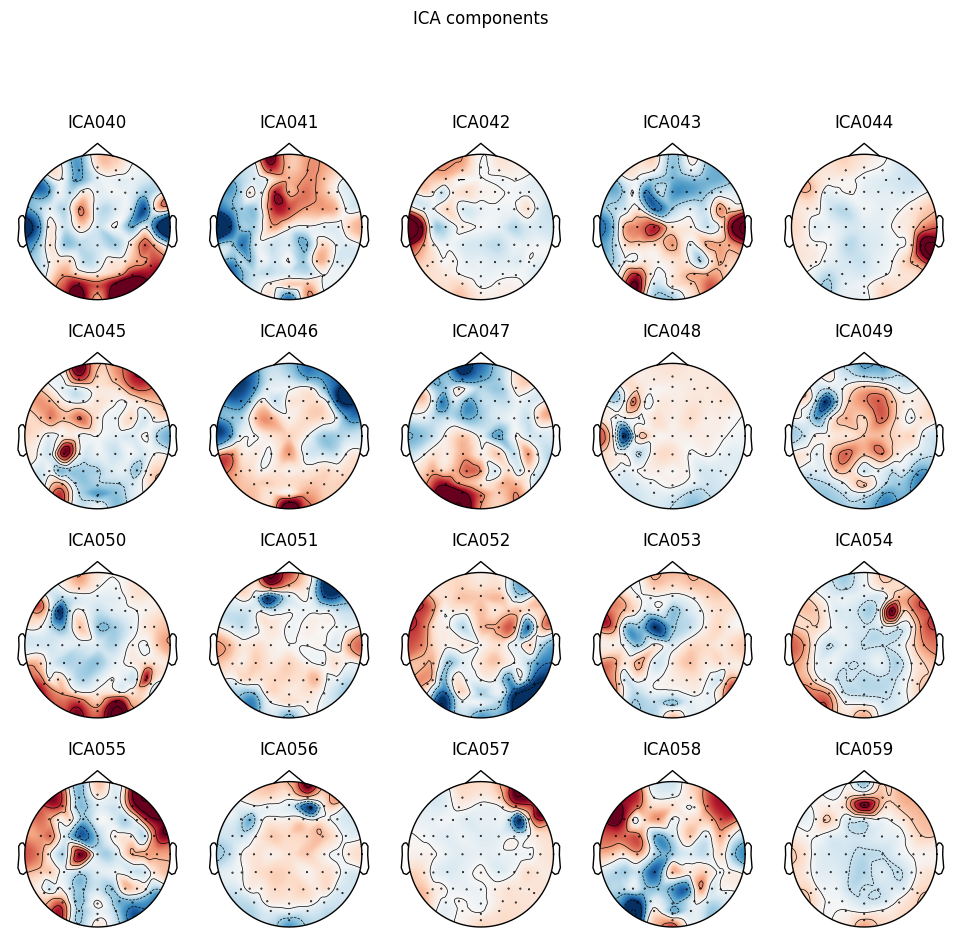

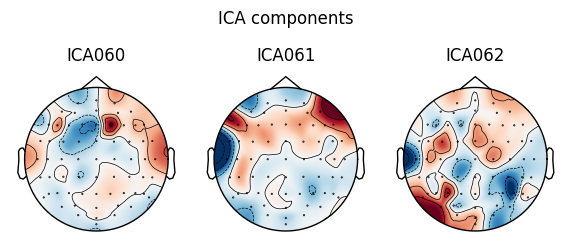

[<MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 585x260.5 with 3 Axes>]

In [10]:
ica_a.plot_components()

In [11]:
ic_a_labels = label_components(raw_down_sampled, ica_a, method='iclabel')

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


In [12]:
print(ic_a_labels)

{'y_pred_proba': array([0.71068704, 0.99965376, 0.97765607, 0.99858904, 0.9998728 ,
       0.9998616 , 0.9718069 , 0.9997542 , 0.999556  , 0.7272505 ,
       0.95335287, 0.8407118 , 0.82914007, 0.9517017 , 0.68499255,
       0.65669835, 0.5653943 , 0.5549538 , 0.7829012 , 0.9412857 ,
       0.6287802 , 0.6103489 , 0.4478123 , 0.76226425, 0.5441758 ,
       0.5921587 , 0.8020158 , 0.9460916 , 0.7951729 , 0.8539858 ,
       0.8224079 , 0.881112  , 0.8483653 , 0.88678277, 0.7090737 ,
       0.9908925 , 0.91010267, 0.76407766, 0.858606  , 0.48336083,
       0.9396587 , 0.77598816, 0.6965105 , 0.9877665 , 0.57639354,
       0.8160002 , 0.4576644 , 0.90256953, 0.6777309 , 0.88062763,
       0.8663895 , 0.70230985, 0.6224536 , 0.6637552 , 0.9431555 ,
       0.96789   , 0.8173577 , 0.5426271 , 0.54120946, 0.8846265 ,
       0.87532467, 0.9055654 , 0.9772924 ], dtype=float32), 'labels': ['brain', 'brain', 'brain', 'brain', 'brain', 'eye blink', 'eye blink', 'brain', 'brain', 'other', 'brain', '

Very interesting that ICA is screaming channel noise for F5, the one PCA heuristic does not like, and the one stability analysis does not like after running ICA.

In [13]:
components = []
for ic in range(63):
    if ic_a_labels['y_pred_proba'][ic] > 0.8:
        if ic_a_labels['labels'][ic] == 'eye blink' or ic_a_labels['labels'][ic] == 'muscle artifact':
            components.append(ic)
            print(ic_a_labels['labels'][ic], ic_a_labels['y_pred_proba'][ic])
print(components)

eye blink 0.9998616
eye blink 0.9718069
muscle artifact 0.9908925
[5, 6, 35]


In [14]:
ica_a.exclude = components

In [15]:
reconstruction = ica_a.apply(epocs_ica)


Applying ICA to Epochs instance


    Transforming to ICA space (63 components)
    Zeroing out 3 ICA components
    Projecting back using 64 PCA components


Between GFP peaks

In [17]:
ic_epoched_stability, ic_epoched_switching_freq, ic_convex_stabilty, ic_significant_switching_freq, ic_peaks, _, _ = epoched_stability2(epocs_ica)

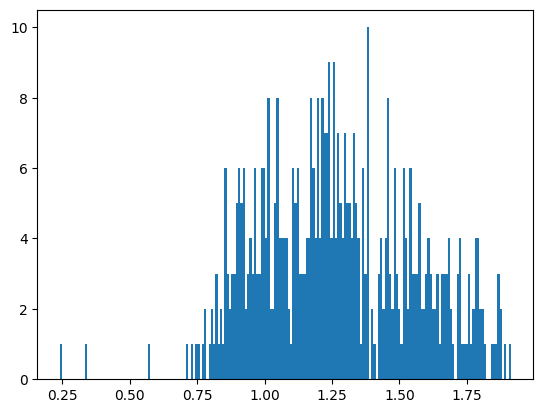

In [18]:
plt.hist(ic_convex_stabilty, bins=200)
plt.show()

In [19]:
timepoints = np.where(ic_convex_stabilty<0.6)[0]
print((timepoints)/2)

[101.  101.5 102. ]


Stability transformed: absoluteDISS = |DISS-1| ... and averaged for each epoch. Now only high values indicate stability.

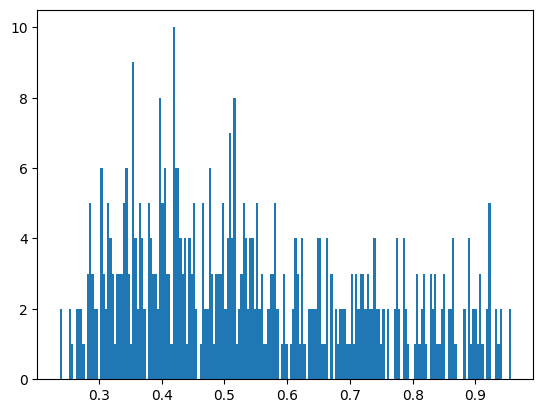

In [20]:
plt.hist(ic_epoched_stability, bins=200)
plt.show()

In [21]:
timepoints = np.where(ic_epoched_stability<0.25)[0]
print((timepoints)/2)

[ 90. 111.]


Average epoch polarity inversion going from gfp peak to gfp peak, meaning DISS < 1.

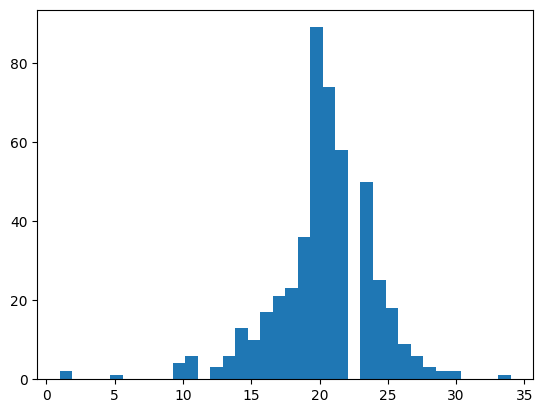

In [22]:
plt.hist(ic_epoched_switching_freq, bins=36)
plt.show()

In [23]:
timepoints = np.where(ic_epoched_switching_freq>30)[0]
print((timepoints)/2)

[110.5]


The same again, but only for shifts in polarity where higher stability is indicated (DISS > 1.4)

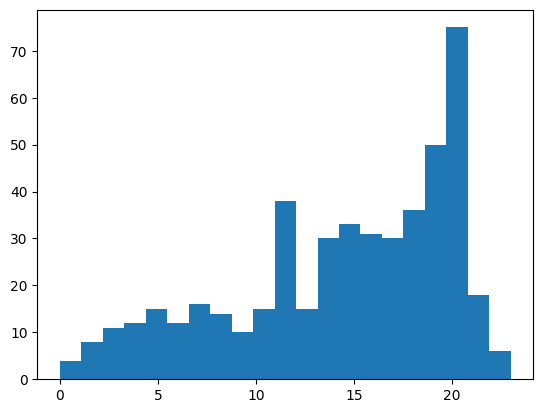

In [24]:
plt.hist(ic_significant_switching_freq, bins=21)
plt.show()

SO after ICA we dont see that anymore (zero switching epochs) , so maybe they were not clean.

Number of GFP peaks for each epoch

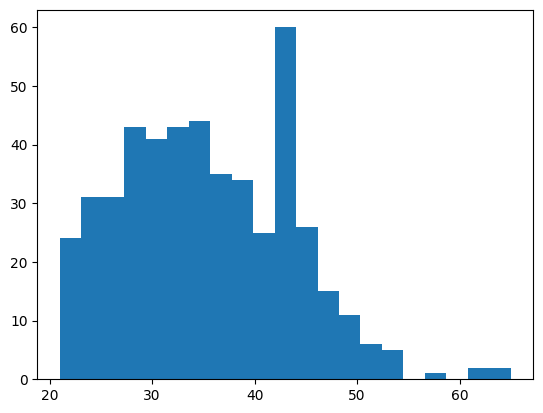

In [25]:
plt.hist(ic_peaks, bins=21)
plt.show()

In [26]:
timepoints = np.where(ic_peaks>50)[0]
print((timepoints)/2)

[ 44.5  82.   87.5  92.  109.  109.5 110.  110.5 111.  111.5 113.  152.
 188.5 229.5 230.  231. ]


Looking at scatter plot between swithcing frequencies and number of GFP peaks

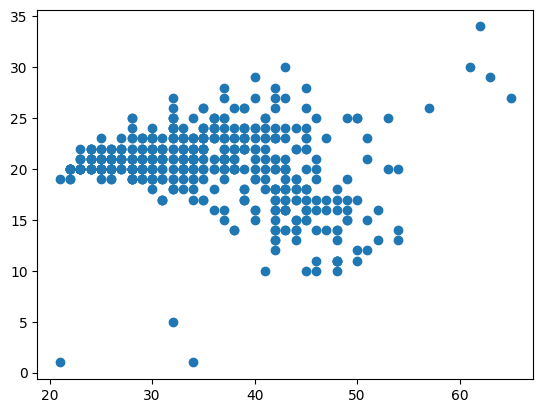

In [27]:
plt.scatter(ic_peaks, ic_epoched_switching_freq)
plt.show()

In [28]:
idx = np.where((ic_epoched_switching_freq < 2))[0]
print((idx-1)/2)

[100.5 101. ]


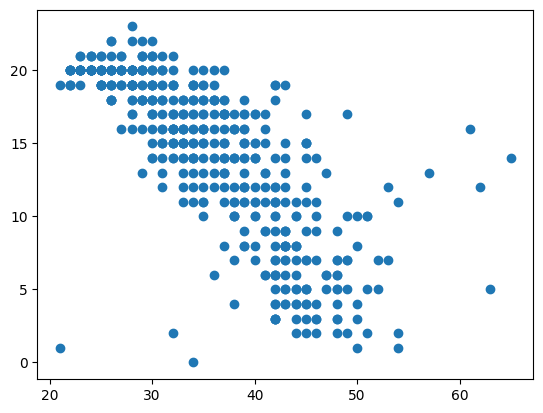

In [29]:
plt.scatter(ic_peaks, ic_significant_switching_freq)
plt.show()

In [30]:
idx = np.where((ic_peaks > 55))[0]
print(idx)
print((idx-1)/2)

idx = np.where((ic_peaks < 28) & (ic_significant_switching_freq < 9))[0]
print((idx-1)/2)

idx = np.where((ic_significant_switching_freq == 0))[0]
print((idx-1)/2)

[218 219 220 221 222]
[108.5 109.  109.5 110.  110.5]
[101.]
[100.5]


Looking at average absoluteDISS in relation to switching frequencies.

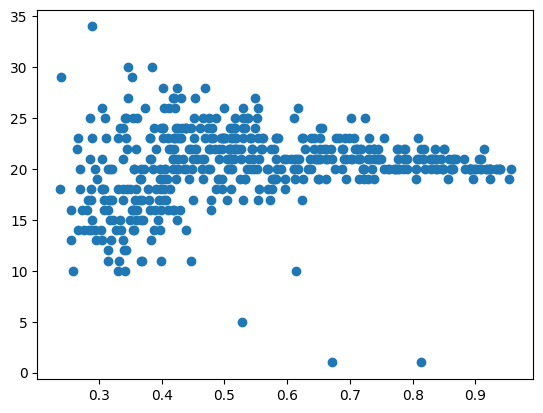

In [31]:
plt.scatter(ic_epoched_stability, ic_epoched_switching_freq)
plt.show()

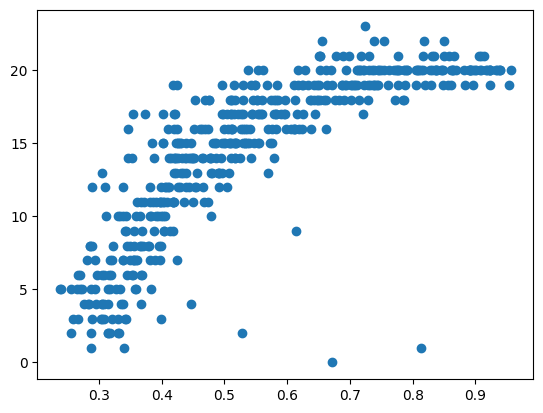

In [32]:
plt.scatter(ic_epoched_stability, ic_significant_switching_freq)
plt.show()

In [33]:
idx = np.where((ic_epoched_stability > 0.5) & (ic_significant_switching_freq < 5))[0]
print((idx-1)/2)

[100.5 101.  101.5]


Same but with average DISS

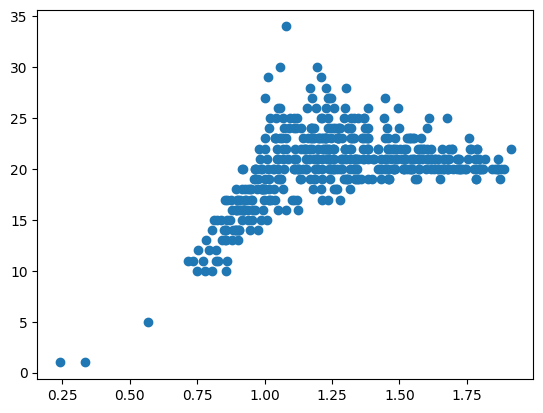

In [34]:
plt.scatter(ic_convex_stabilty, ic_epoched_switching_freq)
plt.show()

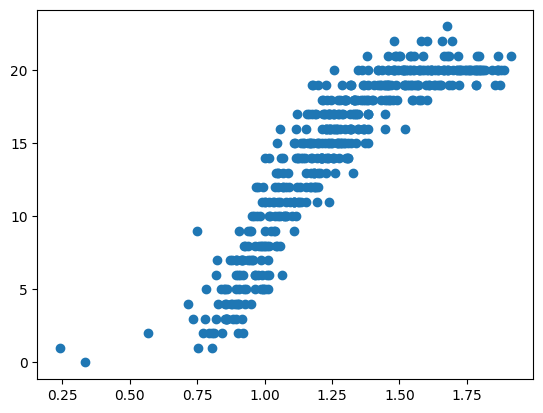

In [35]:
plt.scatter(ic_convex_stabilty, ic_significant_switching_freq)
plt.show()

In [36]:
print(ic_epoched_stability[218], ic_convex_stabilty[218], ic_epoched_switching_freq[218], ic_significant_switching_freq[218])

0.3053999820219471 1.0485794101231112 26.0 13.0


In [37]:
print(ic_epoched_stability[int(109.5*2)], ic_convex_stabilty[int(109.5*2)], ic_epoched_switching_freq[int(109.5*2)], ic_significant_switching_freq[int(109.5*2)])

0.3471390318954263 1.0029342443097036 27.0 14.0


Scatter of the two stability types

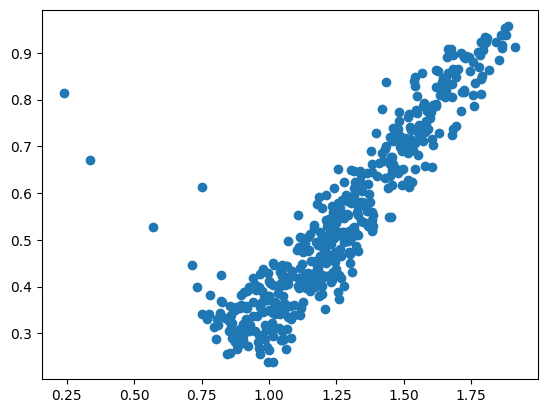

In [38]:
plt.scatter(ic_convex_stabilty, ic_epoched_stability)
plt.show()

In [39]:
idx = np.where((ic_epoched_stability>0.4) & (ic_convex_stabilty<0.75))[0]
print(idx)
print((idx)/2)

[201 202 203 204 317]
[100.5 101.  101.5 102.  158.5]


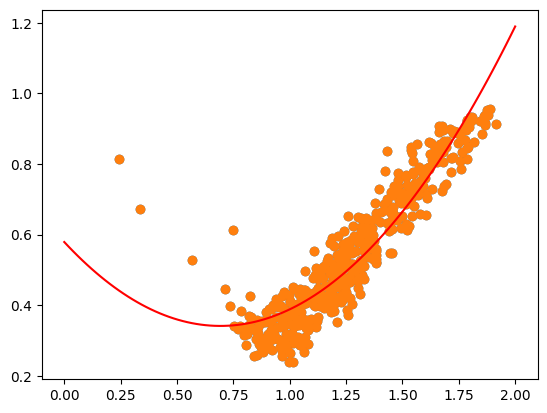

In [41]:
ic_fit = np.poly1d(np.polyfit(ic_convex_stabilty, ic_epoched_stability, 2))
ic_polyline = np.linspace(0, 2, 100)
plt.scatter(ic_convex_stabilty, ic_epoched_stability)
plt.plot(ic_polyline, ic_fit(ic_polyline), color='red')
plt.show()


In [42]:
print(ic_fit)

        2
0.4958 x - 0.6864 x + 0.5789


So it augments the data kind of like i would expect.

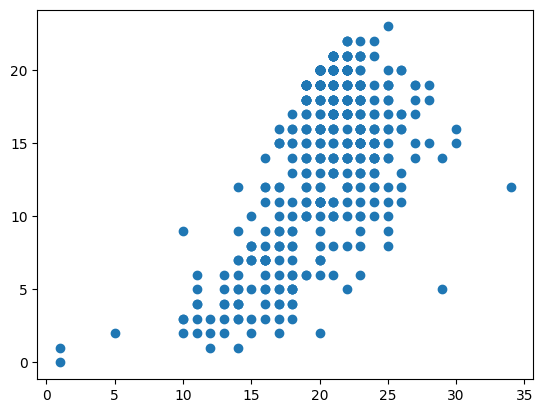

In [43]:
plt.scatter(ic_epoched_switching_freq, ic_significant_switching_freq)
plt.show()

In [44]:
idx = np.where((ic_epoched_switching_freq > 25) & (ic_significant_switching_freq < 15))[0]
print((idx-1)/2)

[ 32.   61.5 108.5 109.  110.  110.5 186. ]


At GFP peaks

In [45]:
ic_at_epoched_stability, ic_at_convex_stabilty = epoched_stability1(epocs_ica)

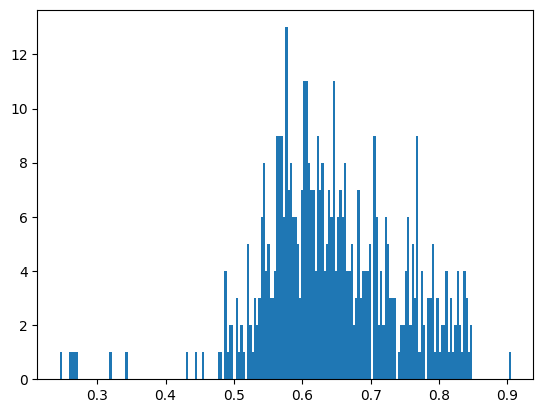

In [46]:
plt.hist(ic_at_epoched_stability, bins=200)
plt.show()

In [47]:
idx = np.where(ic_at_epoched_stability > 0.85)[0]
print((idx-1)/2)
idx = np.where(ic_at_epoched_stability < 0.4)[0]
print((idx-1)/2)

[101.]
[108.  108.5 109.  109.5 110.  110.5 111. ]


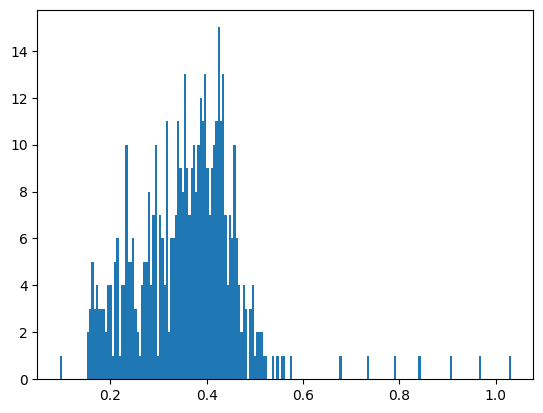

In [48]:
plt.hist(ic_at_convex_stabilty, bins=200)
plt.show()

In [49]:
idx = np.where(ic_at_convex_stabilty > 0.8)[0]
print((idx-1)/2)
idx = np.where(ic_at_convex_stabilty < 0.15)[0]
print((idx-1)/2)

[108.5 109.  109.5 110. ]
[101.]


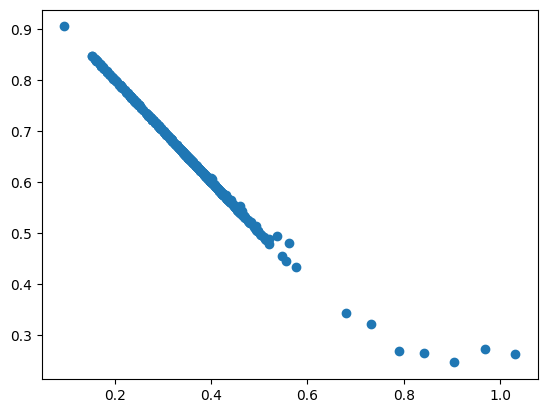

In [50]:
plt.scatter(ic_at_convex_stabilty, ic_at_epoched_stability)
plt.show()

In [91]:
idx = np.where((ic_at_convex_stabilty > 0.6) & (ic_at_epoched_stability < 10))[0]
print((idx-1)/2)

[108.  108.5 109.  109.5 110.  110.5 111. ]


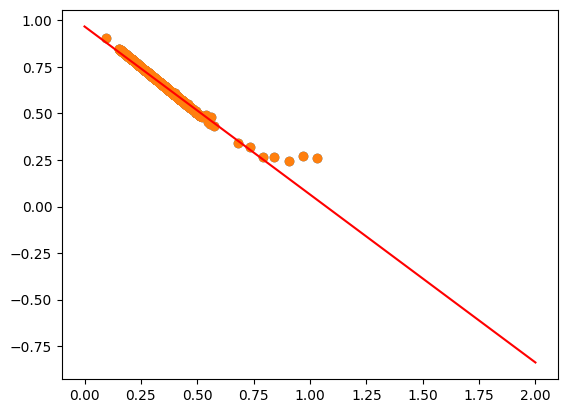

In [53]:
ic_at_fit = np.poly1d(np.polyfit(ic_at_convex_stabilty, ic_at_epoched_stability, 1))
polyline = np.linspace(0, 2, 100)
plt.scatter(ic_at_convex_stabilty, ic_at_epoched_stability)
plt.plot(polyline, ic_at_fit(polyline), color='red')
plt.show()

In [55]:
print(ic_at_fit)

 
-0.9027 x + 0.9674


pca heuristic analysis

In [56]:
#idx = np.where((epoched_stability>=np.median(epoched_stability)) & (convex_stabilty>=np.median(convex_stabilty)) & (at_epoched_stability > np.median(at_epoched_stability)))[0]
#print(idx)

In [57]:
channelstab_epochs = mne.make_fixed_length_epochs(raw_down_sampled, verbose=False, preload=True, duration=0.5)

In [58]:
#anti_idx = np.arange(480)
#anti_idx = np.delete(anti_idx, idx)
#print(anti_idx)

In [59]:
#channelstab_epochs.drop(anti_idx)
#channelstab_epochs.drop([200, 201, 202, 203, 204, 205, 216, 217, 218, 219, 220, 221, 222])

Channel Satbility

In [60]:
def remove_bad(mne_epoch_object, channel_name):
    raw = mne_epoch_object.copy()
    raw.drop_channels(channel_name)
    return raw

In [61]:
def leav_one_out(epochs_object):
    epoched_stability, _, _, _, _, _, _ = epoched_stability2(epochs_object)
    ch_name_list = epochs_object.info['ch_names']
    basline_stability = np.mean(epoched_stability)
    stability_change = np.ndarray(shape=(len(ch_name_list)))
    for c in range(len(ch_name_list)):
        instance = remove_bad(epochs_object, ch_name_list[c])
        stab, _, _, _, _, _, _ = epoched_stability2(instance)
        stability_change[c] = basline_stability - np.mean(stab)        
    return stability_change

In [62]:
def leav_one_out2(epochs_object):
    epoched_stability, _ = epoched_stability1(epochs_object)
    ch_name_list = epochs_object.info['ch_names']
    basline_stability = np.mean(epoched_stability)
    stability_change = np.ndarray(shape=(len(ch_name_list)))
    for c in range(len(ch_name_list)):
        instance = remove_bad(epochs_object, ch_name_list[c])
        stab, _ = epoched_stability1(instance)
        stability_change[c] = basline_stability - np.mean(stab)        
    return stability_change

At GFP peaks

In [70]:
channel_names = np.array(raw_down_sampled.info['ch_names'])

In [63]:
#channelstab_epochs = mne.make_fixed_length_epochs(raw_down_sampled, verbose=False, preload=True, duration=0.5)
at_test1 = leav_one_out2(channelstab_epochs)
#channelstab_epochs.drop([100, 101, 102, 108, 109, 110, 111])
test1 = leav_one_out(channelstab_epochs)

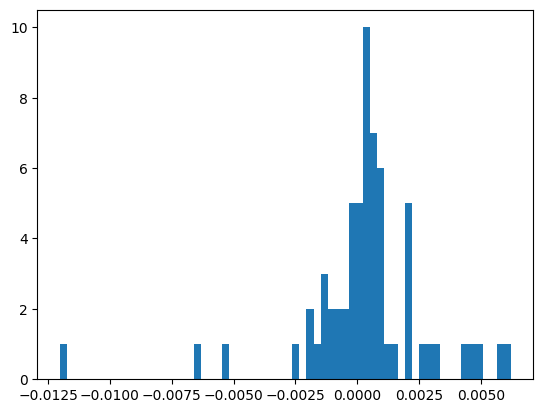

In [64]:
plt.hist(at_test1, bins=64)
plt.show()

In [71]:
order = np.argsort(at_test1)
print(channel_names[order])

['Fp2' 'Fp1' 'T7' 'AF8' 'FC6' 'AF3' 'C6' 'FT8' 'Fpz' 'T8' 'F5' 'F6' 'AF7'
 'C5' 'FC5' 'FT7' 'CP3' 'CP5' 'CP1' 'CP6' 'AF4' 'CP4' 'CP2' 'C4' 'F8' 'P4'
 'Pz' 'P1' 'TP8' 'FC4' 'P2' 'F4' 'AFz' 'C2' 'FC1' 'F3' 'CPz' 'C1' 'P3'
 'P6' 'FC3' 'TP7' 'F7' 'Cz' 'F2' 'F1' 'Fz' 'FC2' 'C3' 'P5' 'FCz' 'P8'
 'PO3' 'POz' 'P9' 'P7' 'PO4' 'P10' 'Iz' 'PO7' 'Oz' 'O1' 'PO8' 'O2']


Between GFP peaks

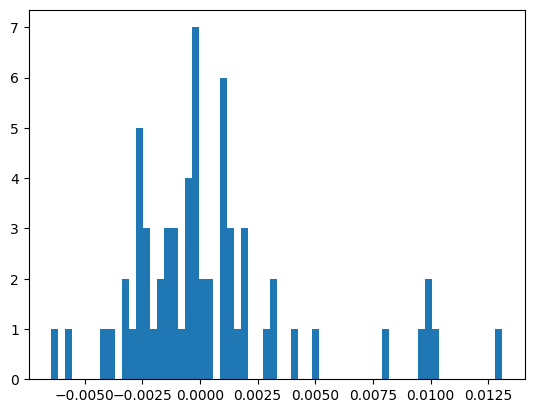

In [72]:
plt.hist(test1, bins=64)
plt.show()

In [73]:
order = np.argsort(test1)
print(channel_names[order])

['Fp1' 'Fp2' 'C6' 'AF7' 'FT8' 'F5' 'T8' 'AF8' 'FC6' 'FC5' 'T7' 'F7' 'C5'
 'CP3' 'FT7' 'F8' 'TP8' 'Fpz' 'CP1' 'CP6' 'F6' 'Pz' 'CP4' 'FC3' 'CPz'
 'CP5' 'P1' 'CP2' 'C1' 'C2' 'P4' 'TP7' 'P2' 'FC1' 'AF3' 'P3' 'C4' 'F3'
 'Cz' 'C3' 'AF4' 'AFz' 'FC2' 'F4' 'F1' 'FCz' 'P5' 'P6' 'POz' 'FC4' 'F2'
 'P7' 'Fz' 'P9' 'PO3' 'P8' 'P10' 'PO4' 'PO7' 'PO8' 'Iz' 'Oz' 'O1' 'O2']


In [74]:
print(kurtosis(test1))
print(skew(test1))

2.0914184663548294
1.3839888522117028


PCA heuristic idea

In [76]:
_, _, _, _, _, data_all, data_at_peaks = epoched_stability2(channelstab_epochs)

In [77]:
data = data_at_peaks.T

In [78]:
scaler = sklearn.preprocessing.StandardScaler()
data = scaler.fit_transform(data)

In [79]:
def pca_auc(data):
    pca = sklearn.decomposition.PCA(random_state=9)
    pca.fit_transform(data)
    roc_curve = np.ndarray(shape=pca.components_.shape[0])
    explained_var = pca.explained_variance_ratio_
    percent = 0
    for v in range(roc_curve.shape[0]):
        percent += explained_var[v]
        roc_curve[v] = percent
    auc = np.trapz(roc_curve.flatten())
    return auc/pca.components_.shape[0], roc_curve

0.9469482996751616


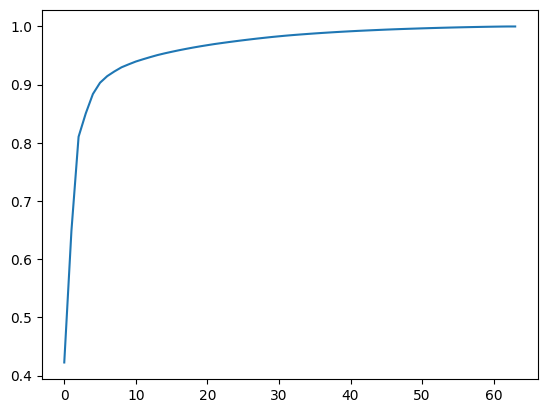

In [80]:
benchmark, rc = pca_auc(data)
print(benchmark)
plt.plot(rc)
plt.show()

In [81]:
pc_all_chanels = np.ndarray(64)
for c in range(len(channel_names)):
    dataaa = np.delete(data, c, axis=1)
    b, r = pca_auc(dataaa)
    pc_all_chanels[c] = b-benchmark

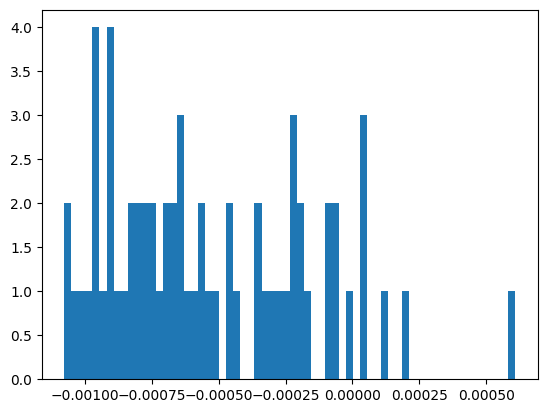

In [82]:
plt.hist(pc_all_chanels, bins=64)
plt.show()

In [83]:
order = np.argsort(pc_all_chanels)
print(channel_names[order])

['O2' 'Oz' 'O1' 'C2' 'PO8' 'PO3' 'Fz' 'FCz' 'Cz' 'P8' 'F2' 'Pz' 'AFz'
 'POz' 'PO4' 'CPz' 'P7' 'FC2' 'P5' 'Iz' 'P2' 'PO7' 'FC4' 'F4' 'P10' 'AF4'
 'F7' 'P6' 'FT7' 'F6' 'P3' 'CP2' 'F8' 'CP1' 'P9' 'TP7' 'P1' 'Fpz' 'TP8'
 'AF3' 'F1' 'F3' 'C1' 'CP4' 'FC5' 'CP5' 'AF7' 'P4' 'FT8' 'Fp1' 'AF8' 'CP6'
 'C4' 'C3' 'FC6' 'C6' 'FC3' 'Fp2' 'T8' 'FC1' 'T7' 'C5' 'F5' 'CP3']


In [84]:
bad_by_corr = np.where(pc_all_chanels > 0)[0]
print(channel_names[bad_by_corr])

['F5' 'FC1' 'C5' 'T7' 'CP3' 'T8']


In [85]:
idx = np.where((at_test1 < 0) & (test1 < 0) & (pc_all_chanels > 0))[0]
print(idx)

[ 5 13 14 17 51]


In [86]:
print(channel_names[idx])

['F5' 'C5' 'T7' 'CP3' 'T8']


In [87]:
idx = np.where((at_test1 < 0) & (pc_all_chanels > 0))[0]
idx2 = np.where((test1 < 0) & (pc_all_chanels > 0))[0]
print(idx)
print(idx2)

[ 5 13 14 17 51]
[ 5 10 13 14 17 51]


In [88]:
print(channel_names[idx])
print(channel_names[idx2])

['F5' 'C5' 'T7' 'CP3' 'T8']
['F5' 'FC1' 'C5' 'T7' 'CP3' 'T8']


Channels to exclude

In [89]:
acum = []
for cn in channel_names[np.argsort(test1)]:
    if cn in channel_names[bad_by_corr]:
        print(cn)
        acum.append(cn)
    else:
        break
for cn in channel_names[np.argsort(at_test1)]:
    if cn in channel_names[bad_by_corr]:
        if cn not in acum:
            print(cn)
    else:
        break
